In [1]:
import numpy as np
from numpy import cos, sin
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read data
acc_1 = pd.read_csv(r'data\24_steps\Accelerometer.csv')
gyro_1 = pd.read_csv(r'data\24_steps\Gyroscope.csv')

In [3]:
# Total acceleration
acc_1['acceleration'] =np.sqrt(acc_1['x']**2+acc_1['y']**2+acc_1['z']**2)

In [4]:
# join dataframes
df1 = acc_1.join(gyro_1.set_index('time'),on="time",lsuffix='_acc', rsuffix='_gyro')


In [5]:
# Define the first sample as '0' and convert from nanoseconds to seconds
df1['time'] = (df1['time']-df1.loc[0,'time'])*(1e-9)

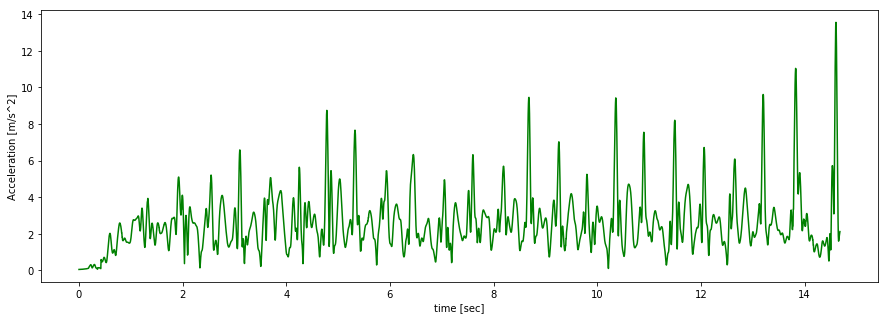

In [11]:
# plot acceleration
fig = plt.figure(figsize=(15,5))
plt.plot(df1['time'],df1['acceleration'], '-g')
plt.xlabel('time [sec]')
plt.ylabel('Acceleration [m/s^2]')
plt.show()

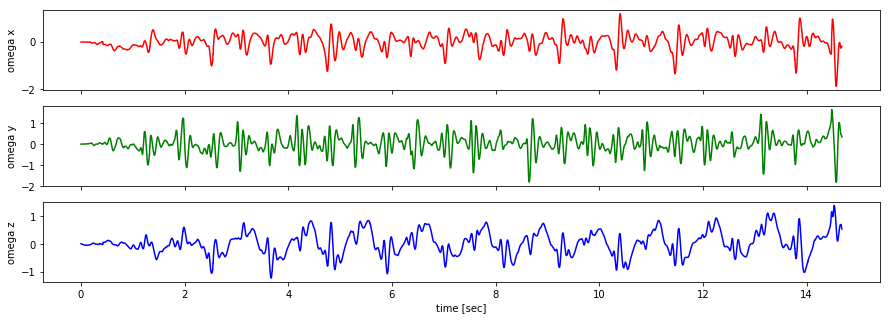

In [12]:
# plot gyroscope data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(df1['time'],df1['x_gyro'], '-r')
axs[0].set_ylabel('omega x')

axs[1].plot(df1['time'],df1['y_gyro'], '-g')
axs[1].set_ylabel('omega y')

axs[2].plot(df1['time'],df1['z_gyro'], '-b')
axs[2].set_ylabel('omega z')

axs[2].set_xlabel('time [sec]')


plt.show()

In [6]:
def v2a_simetric(v):
    a_simertic = np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])
    return a_simertic

In [16]:
# Initial parameters
Re = 6378137
e = 0.0818191908
omega_0 = (2*np.pi)/(24*60*60) # Earth turn rate
# from compass
yaw_0 = np.deg2rad(230)
# Calc' initial angles
fx = df1['x_acc'].mean()
fy = df1['y_acc'].mean()
fz = df1['z_acc'].mean()

roll_0 = np.arctan2(-fy, -fz)
pitch_0 = np.arctan2(-fx, np.sqrt(fz**2 + fy**2))


# from google map
lat_0 = np.deg2rad(32.780724)
lon_0 = np.deg2rad(35.020606)
h_0 = 183

V_0 = np.array([[0,0,0]]).T
R_0 = np.array([[lat_0, lon_0, h_0]]).T

Rm = Re * (1 - e ** 2) / (1 - e ** 2 * sin(lat_0) * 2) ** (3 / 2)
Rn = Re / (1 - e ** 2 * sin(lat_0) * 2) ** (1 / 2)
# g = 9.7803 + 0.051799*sin(lat_0) - h_0*0.94114/1000000
g = np.array([[0,0,9.81]]).T

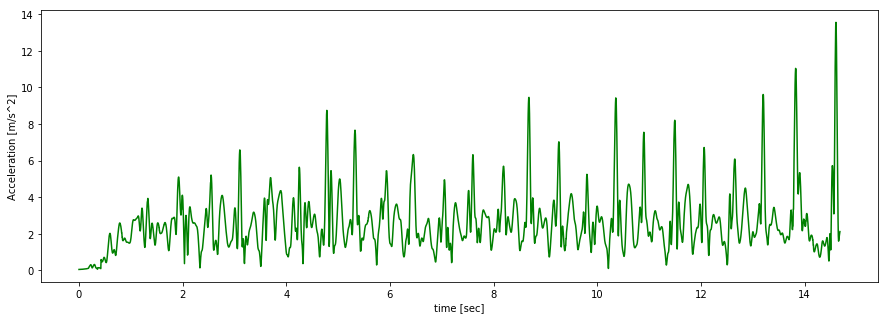

In [17]:
# Rotation matrix
T_roll = np.array([[cos(roll_0),0,-sin(roll_0)],[0,1,0],[sin(roll_0),0,cos(roll_0)]])
T_pitch = np.array([[1,0,0],[0,cos(pitch_0),sin(pitch_0)],[0,-sin(pitch_0),cos(pitch_0)]])
T_yaw = np.array([[cos(yaw_0),sin(yaw_0),0],[-sin(yaw_0),cos(yaw_0),0],[0,0,1]])

T_bn = T_roll.dot(T_pitch.dot(T_yaw))